In [174]:
import dlib, cv2, os, glob, shutil, urllib.request, requests
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from imutils import face_utils

class DogExpression():
    def __init__(self):
        self.setSettings()

    def setSettings(self):
        self.detector = dlib.cnn_face_detection_model_v1('dogHeadDetector.dat')
        self.predictor = dlib.shape_predictor('landmarkDetector.dat')

        self.src_path = './data/dog/'
        self.dst_path = './data/dog/dog_head/'     

        self.image_w = 150
        self.image_h = 150

        self.src_dir = './data/labels/'
        self.train_dir = './data/train/'
        self.test_dir = './data/test/'
        self.val_dir = './data/val/'

        self.categories = []
        self.nb_classes = 8
        self.batch_size = 16
        
    def cropData(self):
        if os.path.exists(self.dst_path):
            shutil.rmtree(self.dst_path)
        os.mkdir(self.dst_path)

        file_list = glob.glob(self.src_path + '*.jpg')

        for i,f in enumerate(file_list):
            if os.path.isfile(f):
                print('file : ' + f)
                ff = np.fromfile(f, np.uint8)
                img = cv2.imdecode(ff, cv2.IMREAD_UNCHANGED)
                #img = cv2.imread(f)
                
                # 너무 커서 오래걸리므로 resize 해서 진행
                result_img = img.copy()
                result_img = cv2.resize(result_img, dsize=(0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
                dets = self.detector(result_img, upsample_num_times=1)

                if len(dets) > 0 :
                    r = dets[0].rect
                    x1, y1 = r.left(), r.top()
                    x2, y2 = r.right(), r.bottom()

                    x1 = 0 if x1<0 else x1
                    y1 = 0 if y1<0 else y1
                    x2 = 0 if x2<0 else x2
                    y2 = 0 if y2<0 else y2

                    img = img[y1*2:y2*2, x1*2:x2*2]                    
                    cv2.imwrite(self.dst_path + str(i) + '.jpg', img)

        result_list = glob.glob(self.dst_path + '*.jpg')
        print('comlete!!')
        print('original   data : ' + str(len(file_list)))
        print('tlansrated data : ' + str(len(result_list))) 
        
    # augmentation
    def augmentateData(self):
        datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
        
        label_list = os.listdir(self.src_dir)
        for label in label_list:
            dst_path = self.train_dir + label + '/'
            os.mkdir(dst_path)
            
            folder_path = self.src_dir + label + '/'    
            file_list = glob.glob(folder_path + '*.jpg')           
            
            for file in file_list:
                img = load_img(file)                
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                
                i = 0                
                for batch in datagen.flow(x, batch_size=1, save_to_dir=dst_path, save_prefix=label, save_format='jpg'):
                    i+=1
                    if i>20:
                        break    
                        
    def loadData(self):        
        self.train_datagen = ImageDataGenerator(rescale = 1./255,
                                                rotation_range=40,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range = 0.2,
                                                zoom_range = 0.2,
                                                horizontal_flip = True,
                                                fill_mode='nearest')
        
        self.train_generator = self.train_datagen.flow_from_directory(
                                                self.train_dir,           
                                                target_size = (image_w, image_h),
                                                batch_size = self.batch_size,
                                                class_mode = 'categorical')
        
        # for test and vali
        self.test_datagen = ImageDataGenerator(rescale=1./255)
        self.test_generator = self.test_datagen.flow_from_directory(
                                                self.test_dir,
                                                target_size =(image_w, image_h),    
                                                batch_size = self.batch_size,
                                                class_mode = 'categorical')   
        
        self.val_datagen = ImageDataGenerator(rescale = 1./255)
        self.val_generator = self.test_datagen.flow_from_directory(
                                                self.test_dir,
                                                target_size = (image_w, image_h),    
                                                batch_size = self.batch_size,
                                                class_mode = 'categorical')   
        
    def trainData(self):
        self.model.fit_generator(self.train_generator,
                                steps_per_epoch=10,
                                epochs=50,
                                validation_data=self.val_generator)        
    def evaluateModel(self):
        print("-- Evaluate --")
        scores = self.model.evaluate_generator(self.test_generator, steps=5)
        print("%s: %.2f%%" %(self.model.metrics_names[1], scores[1]*100))    
        
    def makeModel(self):
        np.random.seed(3)
        
        self.model = Sequential()
        self.model.add(Conv2D(32, (3,3), input_shape=(3, self.image_w, self.image_h), activation = 'relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        
        self.model.add(Conv2D(64, (3,3), input_shape=(3, self.image_w, self.image_h), activation = 'relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        
        self.model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
        self.model.add(Dense(256, activation = 'relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.nb_classes, activation = 'softmax'))
        
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        
if __name__ == '__main__':
    print('dog expressions')
    #de = DogExpression()
    #de.cropData()
    #de.train()         

dog expressions


In [169]:
de = DogExpression()

In [142]:
#de.cropData()

In [143]:
# 필요시 사용
#de.augmentateData()

In [144]:
de.loadData()

In [136]:
de.makeModel()

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_6/MaxPool' (op: 'MaxPool') with input shapes: [?,1,148,32].

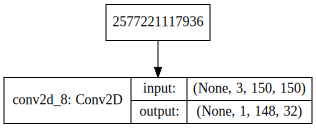

In [137]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(de.model, show_shapes=True).create(prog='dot', format='svg'))

In [138]:
de.trainData()

AttributeError: 'DogExpression' object has no attribute 'train_generator'

In [199]:
de.evaluateModel()

-- Evaluate --
acc: 20.00%
